In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [2]:
# @hidden_cell

CLIENT_ID = '1J15P1PR0GMVR1YRCUV445HWOPDZ4AR0ATNJK4QWICJ3HMAS' # your Foursquare ID
CLIENT_SECRET = 'HPZE5TJKMWFZN4EXM4TCSWMPRNLHR13PCB2Q1HJ5PBMIOMTA' # your Foursquare Secret
VERSION = '20191010'
LIMIT = 60
#

#### San Francisco and Los Angeles: latitude and longitude

In [3]:
SF_latitude = 37.7749
SF_longitude = -122.4194

LA_latitude = 34.0522
LA_longitude = -118.2437
print(SF_latitude, SF_longitude)
print(LA_latitude, LA_longitude)

37.7749 -122.4194
34.0522 -118.2437


## 1. Search for a specific venue category
> `https://api.foursquare.com/v2/venues/`**search**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&query=`**QUERY**`&radius=`**RADIUS**`&limit=`**LIMIT**

In [4]:
search_query = 'hotel'
radius = 1000
print(search_query + ' .... OK!')

hotel .... OK!


####  1.1 let's define a query to search for hotels that is within 1000 meters from San Franscisco. 

In [5]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, SF_latitude, SF_longitude, VERSION, search_query, radius, LIMIT)

In [6]:
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4aaeac2af964a520e06220e3,1231 Market St,US,San Francisco,United States,at 8th St.,528,"[1231 Market St (at 8th St.), San Francisco, C...","[{'label': 'display', 'lat': 37.77794, 'lng': ...",37.777940,-122.414790,NaN,94103,CA,Hotel Whitcomb,v-1571842894,NaN
1,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,49f903caf964a5204e6d1fe3,601 Eddy St,US,San Francisco,United States,at Larkin St.,900,"[601 Eddy St (at Larkin St.), San Francisco, C...","[{'label': 'display', 'lat': 37.78292626633365...",37.782926,-122.418090,NaN,94109,CA,Phoenix Hotel,v-1571842894,NaN
2,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4a1873b6f964a520b4791fe3,112 7th St,US,San Francisco,United States,Mission St,883,"[112 7th St (Mission St), San Francisco, CA 94...","[{'label': 'display', 'lat': 37.77885717, 'lng...",37.778857,-122.410690,NaN,94103,CA,Good Hotel,v-1571842894,33104272
3,"[{'id': '5032897c91d4c4b30a586d69', 'name': 'P...",False,4b686ec8f964a5204b782be3,25 14th St,US,San Francisco,United States,Folsom,823,"[25 14th St (Folsom), San Francisco, CA 94103,...","[{'label': 'display', 'lat': 37.76879141486054...",37.768791,-122.414115,NaN,94103,CA,WAG Hotel,v-1571842894,551573772
4,"[{'id': '4bf58dd8d48988d123941735', 'name': 'W...",False,43fb0c0ef964a520df2f1fe3,45 Rose St,US,San Francisco,United States,at Market St.,284,"[45 Rose St (at Market St.), San Francisco, CA...","[{'label': 'display', 'lat': 37.77350386431412...",37.773504,-122.422110,NaN,94102,CA,Hotel Biron,v-1571842894,NaN


#### Define information of interest and filter dataframe

In [7]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    #print(categories_list)   
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]


In [56]:
venues_map = folium.Map(location=[SF_latitude, SF_longitude], zoom_start=15) # generate map centred around the Conrad Hotel


for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

####  1.2 let's define a query to search for hotels that is within 1000 meters from Los Angeles 

In [9]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LA_latitude, LA_longitude, VERSION, search_query, radius, LIMIT)

In [10]:
LA_results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = LA_results['response']['venues']

# tranform venues into a dataframe
LA_dataframe = json_normalize(venues)
LA_dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4a62ae6cf964a52072c41fe3,404 S Figueroa St,US,Los Angeles,United States,btwn 4th & 5th St,1072,"[404 S Figueroa St (btwn 4th & 5th St), Los An...","[{'label': 'display', 'lat': 34.0527471, 'lng'...",34.052747,-118.255312,NaN,90071,CA,"The Westin Bonaventure Hotel & Suites, Los Ang...",v-1571842902,NaN
1,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4a6b9a88f964a52052cf1fe3,506 S Grand Ave,US,Los Angeles,United States,at 5th St,980,"[506 S Grand Ave (at 5th St), Los Angeles, CA ...","[{'label': 'display', 'lat': 34.049813, 'lng':...",34.049813,-118.253938,NaN,90071,CA,Millennium Biltmore Hotel Los Angeles,v-1571842902,NaN
2,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4a6be87ef964a5203ad01fe3,251 S Olive St,US,Los Angeles,United States,NaN,623,"[251 S Olive St, Los Angeles, CA 90012, United...","[{'label': 'display', 'lat': 34.05249694980792...",34.052497,-118.250455,NaN,90012,CA,Omni Los Angeles Hotel at California Plaza,v-1571842902,498793678
3,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4a47ab0ff964a520eca91fe3,328 E 1st St,US,Los Angeles,United States,NaN,428,"[328 E 1st St, Los Angeles, CA 90012, United S...","[{'label': 'display', 'lat': 34.04974909864657...",34.049749,-118.240111,NaN,90012,CA,Miyako Hotel,v-1571842902,NaN
4,"[{'id': '4c38df4de52ce0d596b336e1', 'name': 'P...",False,4cd50b6876ab721ebce76a6a,120 S Los Angeles St,US,Los Angeles,United States,NaN,208,"[120 S Los Angeles St, Los Angeles, CA 90012, ...","[{'label': 'display', 'lat': 34.050526, 'lng':...",34.050526,-118.242682,NaN,90012,CA,Kyoto Grand Hotel Parking & Gardens Garage,v-1571842902,NaN


In [11]:
# keep only columns that include venue name, and anything that is associated with location
LA_filtered_columns = ['name', 'categories'] + [col for col in LA_dataframe.columns if col.startswith('location.')] + ['id']
LA_dataframe_filtered = LA_dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    #print(categories_list)   
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
LA_dataframe_filtered['categories'] = LA_dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
LA_dataframe_filtered.columns = [column.split('.')[-1] for column in LA_dataframe_filtered.columns]


In [12]:
venues_map = folium.Map(location=[LA_latitude, LA_longitude], zoom_start=15) # generate map centred around the Conrad Hotel

for lat, lng, label in zip(LA_dataframe_filtered.lat, LA_dataframe_filtered.lng, LA_dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

## 2. Explore a Given Venue
> `https://api.foursquare.com/v2/venues/`**VENUE_ID**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&v=`**VERSION**

### 2.1. Let's find all the hotels from SF that haven been rated

In [13]:
#SF_Data = []
SF_ratings = {}
for venue_id in dataframe_filtered['id']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    #print(result['response']['venue'].keys())
    # result['response']['venue']
    
    try:
        # ratings.append(result['response']['venue']['rating'])
        #print(result['response']['venue']['attributes']['groups'][0]['summary'])
        #li = [SF_ratings[result['response']['venue']['name']],  result['response']['venue']['rating'], result['response']['venue']['attributes']['groups'][0]['summary'] ]
        SF_ratings[result['response']['venue']['name']] = result['response']['venue']['rating']
        SF_Data.append(li)
    except:
        print('%s This venue has not been rated yet.'%result['response']['venue']['name'])

Hotel Whitcomb This venue has not been rated yet.
Phoenix Hotel This venue has not been rated yet.
Good Hotel This venue has not been rated yet.
WAG Hotel This venue has not been rated yet.
Hotel Biron This venue has not been rated yet.
Hotel Bijou This venue has not been rated yet.
The Lyric Hotel/Conard House This venue has not been rated yet.
Proper Hotel San Francisco This venue has not been rated yet.
Midori Hotel/Conard House This venue has not been rated yet.
BEI Hotel San Francisco This venue has not been rated yet.
Cova Hotel This venue has not been rated yet.
El Dorado Hotel/Conard House This venue has not been rated yet.
Casa Loma Hotel This venue has not been rated yet.
Embassy Hotel This venue has not been rated yet.
Parking Whitcomb Hotel This venue has not been rated yet.
Hotel Iroquois This venue has not been rated yet.
Hotel Metropolis This venue has not been rated yet.
Hotel Essex This venue has not been rated yet.
Zipcar Cova Hotel This venue has not been rated yet.


### 2.2. Let's find all the hotels from LA that haven been rated

In [14]:
LA_ratings = {}
for venue_id in LA_dataframe_filtered['id']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    #print(result['response']['venue'].keys())
    # result['response']['venue']
    try:
        # ratings.append(result['response']['venue']['rating'])
        LA_ratings[result['response']['venue']['name']] = result['response']['venue']['rating']
    except:
        print(' This venue has not been rated yet.')

 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rated yet.
 This venue has not been rat

## 3. Compare Hotel rate between SF and LA

In [47]:
df_SF = pd.DataFrame(list(SF_ratings.items()), columns=['SF Hotel Name', 'SF Rate']).sort_values(by=['SF Rate'], ascending=False)
df_LA = pd.DataFrame(list(LA_ratings.items()), columns=['LA Hotel Name', 'LA Rate']).sort_values(by=['LA Rate'], ascending=False)

In [50]:
df_SF

,SF Hotel Name,SF Rate
4,Hotel Biron,9.0
3,WAG Hotel,8.9
17,Hotel Tonight,8.6
6,Proper Hotel San Francisco,8.4
15,Axiom Hotel,8.1
1,Phoenix Hotel,8.0
5,Hotel Bijou,7.6
19,Warfield Hotel,7.3
12,HOTEL EPIK,6.4
9,Casa Loma Hotel,6.3


In [51]:
df_LA

,LA Hotel Name,LA Rate
0,"The Westin Bonaventure Hotel & Suites, Los Ang...",8.0
2,Omni Los Angeles Hotel at California Plaza,7.8
1,Millennium Biltmore Hotel Los Angeles,7.6
5,Rendezvous Court at Millennium Biltmore Hotel ...,6.8
7,DoubleTree by Hilton Los Angeles Downtown,6.8
3,Miyako Hotel,6.4
6,Metro Plaza Hotel,6.0
4,Kawada Hotel,5.6
9,Stay Hotel,5.1
8,Stay On Main Hotel,4.9


In [52]:
df_hotel = pd.concat([df_SF, df_LA], axis=1)

In [53]:
df_hotel

,SF Hotel Name,SF Rate,LA Hotel Name,LA Rate
0,Hotel Whitcomb,5.0,"The Westin Bonaventure Hotel & Suites, Los Ang...",8.0
1,Phoenix Hotel,8.0,Millennium Biltmore Hotel Los Angeles,7.6
2,Good Hotel,5.3,Omni Los Angeles Hotel at California Plaza,7.8
3,WAG Hotel,8.9,Miyako Hotel,6.4
4,Hotel Biron,9.0,Kawada Hotel,5.6
5,Hotel Bijou,7.6,Rendezvous Court at Millennium Biltmore Hotel ...,6.8
6,Proper Hotel San Francisco,8.4,Metro Plaza Hotel,6.0
7,BEI Hotel San Francisco,5.9,DoubleTree by Hilton Los Angeles Downtown,6.8
8,Cova Hotel,5.8,Stay On Main Hotel,4.9
9,Casa Loma Hotel,6.3,Stay Hotel,5.1


In [54]:
import matplotlib.pyplot as plt

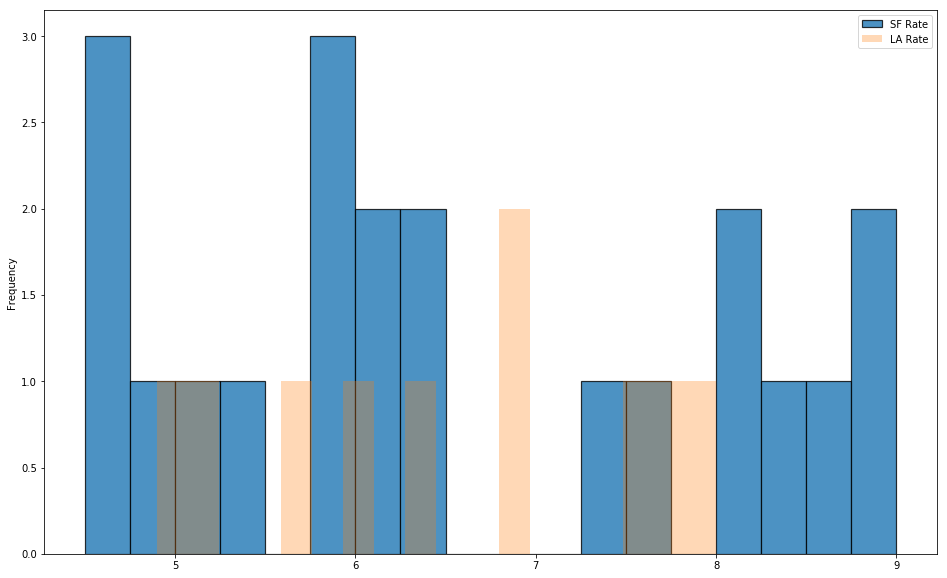

In [55]:
fig = plt.figure(figsize = (16,10))
ax = fig.gca()
df_SF.plot.hist(bins=18, alpha=0.8,edgecolor='black', linewidth=1.2,  ax = ax)
df_LA.plot.hist(bins=18, alpha=0.3, ax = ax)